In [1]:
#imports 
!pip install seaborn 
import numpy as np
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import astropy.units as u
import seaborn as sns
import random
sns.set_style("whitegrid")

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.2
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
%matplotlib inline

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#defining constants
e=-1.6*(10**-19)*u.coulomb #electronic charge
a=5.3*(10**-11)*u.m #bohr radius
ke=9.0*(10**9)*u.kg*(u.m**3)*(u.coulomb**(-2))*(u.s**-2) #constant in the coulomb force
me=9.1*(10**-31)*u.kg #mass of the electron
ioncharge=110*e #charge of the ion
c=3.0*10**8*u.m/u.s #the speed of light
epsilon_0= 8.8*10**-12*(u.coulomb**2)*(u.s**-2)*(u.kg**-1)*(u.m**-3) #permittivity of free space

In [3]:
 def force(r):
    #the Coulomb acceleration
    return -ke*ioncharge*e/(r**2)/me

def euler_solver(x0, y0, v0x, v0y, tf, N):
    """
    Using euler's method to solve the differential equation f=ma
    
    x0=initial x-position
    y0= initial y-position
    idem for v
    tf=final time
    N=number of steps
    """
    vx=v0x
    vy=v0y
    
    x=x0
    y=y0
    accx=0.0
    accy=0.0
    
    pos=[]
    vels=[]
    ts=[]
    accs=[]
    
    tstep=tf/N
    for t in np.logspace(-7, np.log10(tf.value), N)*u.s:
        r=np.sqrt(x**2+y **2)
        theta=np.arctan(abs(y/x))
        acc=force(r)
        
        #calculate the x and y components of the acceleration, velocity and position
        accx=acc*np.cos(theta)
        accy=acc*np.sin(theta)
        #print ('accleration {} {}'.format(accx, accy))
        
        vx = vx+tstep*accx
        vy = vy+tstep*accy
        
        #print (vy)
        x = tstep*vx+x
        y = tstep*vy+y #y should be decreasing while x is increasing 
        #print (h)
        pos.append([x.value, y.value])
        vels.append([vx.value, vy.value])
        ts.append(t.value)
        accs.append([accx.value, accy.value])
        
    pos=np.array(pos)*u.m
    vels=np.array(vels)*u.m/u.s
    ts=np.array(ts)*u.s
    accs=np.array(accs)*u.m/(u.s**2)
    
    #print (ts)
    return {'pos':pos, 'v':vels, 't':ts, 'ac':accs}

### Plots of Velocity, Position and Acceleration

In the following plot, I simulated N electrons with different initial positions around and moving at different random velocties in the x-direction <br>
The paths in position space (or  velocity and accelration) are not deformed, it's the nature of my time steps

Green: Y-direction <br>
Blue: X-direction

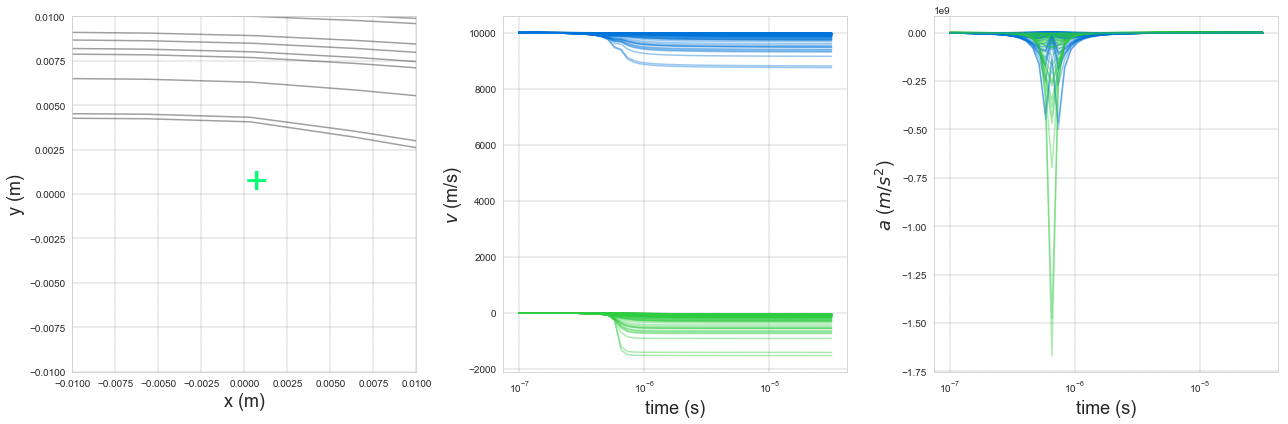

In [4]:
#normalize the colormap for pollting 
norm = mpl.colors.Normalize(vmin=10**8, vmax=10**9)
cmap = cm.cividis
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig, (ax0, ax1, ax2)=plt.subplots(ncols=3, figsize=(18, 6))

pos_ys=10**-1*np.random.random(100)+0.0025
vel_xs=10**4*np.ones(100)#*np.random.random(10)*

tf=10**-4.5*u.s

all_paths=[]
for y, vx in zip(pos_ys*u.m, vel_xs) :
    vals=euler_solver( -10**-1*u.m, y,  vx*u.m/u.s, 0.0*u.m/u.s, tf, 50)
    ax0.plot(vals['pos'][:,0], vals['pos'][:,1],   alpha=.4,color='#111111')
    all_paths.append(vals)
    
    #I'm plotting the total velocity vs time
    ax1.plot(vals['t'], vals['v'][:,0], c='#0074D9', alpha=0.4, label='vx')
    ax1.plot(vals['t'], vals['v'][:,1], c='#2ECC40', alpha=0.4, label='vy')

    ax2.plot(vals['t'], vals['ac'][:,0], c='#0074D9', alpha=0.4, label='ax')
    ax2.plot(vals['t'], vals['ac'][:,1], c='#2ECC40', alpha=0.4, label='ay')


ax0.set_xlabel('x (m)', fontsize=18)
ax0.set_ylabel('y (m)', fontsize=18)

#ax1.set_xlim([0, tf.value/100.])
ax1.set_xlabel('time (s)', fontsize=18)
ax1.set_ylabel(r'$v$ (m/s)', fontsize=18)
#ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.legend()

#ax2.set_xlim([0, tf.value/100.])
ax2.set_xlabel('time (s)', fontsize=18)
ax2.set_ylabel(r'$a$ ($m/s^2$)', fontsize=18)
#ax2.set_yscale('log')
ax2.set_xscale('log')
#ax2.legend()



ax0.set_xlim(np.array([-10**-1, 10**-1])*0.1)
ax0.set_ylim(np.array([-10**-1, 10**-1])*0.1)
ax0.text(0.0, 0.0, '+', fontsize=40, color='#01FF70') #this seems looks off in the actual image
#ax.scatter([0], [0], 'x')

plt.tight_layout()

In [5]:
paths_df=pd.DataFrame(all_paths)

### Power radiated

Calculate the fourier transform of the acceleration, 

$$Power \sim  \mathscr{F}_\nu (a^2) $$

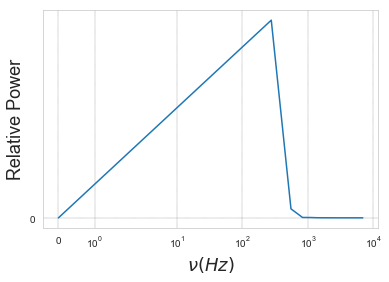

In [6]:
wmaxs=[]
bs=[]
for idx in paths_df.index:
    t=paths_df['t'][idx]
    acc=paths_df['ac'][idx]
    tot_acc=np.sqrt(acc[:,0]**2 +acc[:,1]**2)
    vx=paths_df.v[idx][:,0][0].value
    freq, sp =periodogram(tot_acc**2, 100/np.nanmean(vx/tot_acc).value) #Sampling frequency estimated from the number of steps
    wmaxs.append(np.log10(freq[np.argmax(sp)]))
    ys=paths_df.pos[idx][:,1]
    bs.append(np.nanmin(ys[ys>0.0]).value) #take the closest approach to the nucleus

plt.plot(freq, sp*10**-42, '-')
plt.xlabel(r'$\nu (Hz)$', fontsize=18)
plt.ylabel(r'Relative Power', fontsize=18)
plt.xscale('symlog')
plt.yscale('symlog')
#plt.xlim([10**2, 10**9])

### Impact Parameter
Plot of impact parameter vs max frequency

Comment: There seems to be a weak linear trend, electrons that came closer to the nucleus peaked at higher frequencies

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


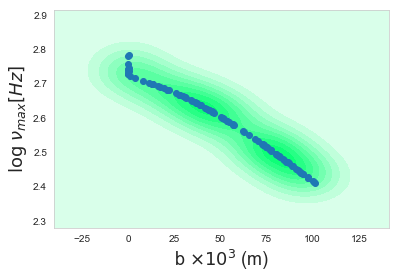

In [7]:
fig, ax=plt.subplots()
bs=np.array(bs)
sns.kdeplot(bs*1000, np.array(wmaxs), ax=ax, shade=True, color='#01FF70')
ax.set_xlabel(r'b $\times$$10^3$ (m)', fontsize=18)
ax.set_ylabel(r'$\log$ $\nu _{max} [Hz]$', fontsize=18)
ax.scatter(bs*1000, np.array(wmaxs))
